<a href="https://colab.research.google.com/github/luizamaral2906/yolov4-treino-customizado/blob/main/Editavel_YOLOv4_Training_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a YOLOv4 Object Detector with Darknet in the Cloud! (GPU ENABLED)
This tutorial will help you build YOLOv4 easily in the cloud with GPU enabled so that you can run object detections in milliseconds!

## GPUs mais rápidas

<p>Os utilizadores que compraram um dos planos pagos do Colab têm acesso a GPUs premium. Pode atualizar as definições da GPU do bloco de notas em <code>Tempo de execução &gt; Alterar tipo de tempo de execução</code> no menu para ativar o acelerador premium. Selecionar uma GPU premium, sujeita a disponibilidade, pode dar-lhe acesso a uma GPU Nvidia V100 ou A100.</p>
<p>A versão sem custo financeiro do Colab dá acesso às GPUs T4 da Nvidia, sujeito a restrições de quota e disponibilidade.</p>

Pode ver que GPU lhe foi atribuída em qualquer altura ao executar a seguinte célula. Se o resultado da execução da célula de código abaixo for "Not connected to a GPU", pode alterar o tempo de execução ao aceder a <code>Tempo de execução &gt; Alterar tipo de tempo de execução</code> no menu para ativar um acelerador de GPU e, em seguida, voltar a executar a célula de código.

Para usar uma GPU com o seu bloco de notas, selecione o menu <code>Tempo de execução &gt; Alterar tipo de tempo de execução</code> e, em seguida, defina o menu pendente de acelerador de hardware para GPU.

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 22 14:14:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mais memória

Os utilizadores que compraram um dos planos pagos do Colab têm acesso a VMs &#40;máquinas virtuais&#41; com muita memória, quando estão disponíveis.
Pode ver quanta memória tem disponível em qualquer altura ao executar a seguinte célula de código. Se o resultado da execução da célula de código abaixo for "Not using a high-RAM runtime", pode ativar um tempo de execução com RAM alta em <code>Tempo de execução &gt; Alterar tipo de tempo de execução</code> no menu. Em seguida, selecione RAM alta no menu pendente Forma do tempo de execução. Depois, execute novamente a célula de código.

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
################### DICAS AMARAL
#######################################################
#a) Mover pasta obj e test para dentro da pasta data (depois de de-zipar todas as imagens)
#b) Mudar subdivisions de 16 para 32 no config.cfg. (com 16 apresentou problemas na execução do cuda) 

#https://github.com/AlexeyAB/darknet/issues/7153
#ERRO NO CUDA --> Solução: item (b) acima

# Step 2: Cloning and Building Darknet
The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

Do not worry about any warnings when you run the '!make' cell!

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# verify CUDA
!/usr/local/cuda/bin/nvcc --version

# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)


In [6]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# cd back into the darknet folder to run detections
%cd darknet

/content
Mounted at /content/gdrive
 Colab	'Colab Notebooks'  'My Drive'
/content/darknet


## i) Cfg File
Copy over the yolov4.cfg to your Google Drive by running the cell below. This will allow us to edit it in a text editor.

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

If you downloaded cfg to google drive you can use the built in  **Text Editor** by going to your google drive and double clicking on yolov4-obj.cfg and then clicking on the **Open with** drop down and selectin **Text Editor**.

**(Image from previous tutorial so don't mind different file name)**

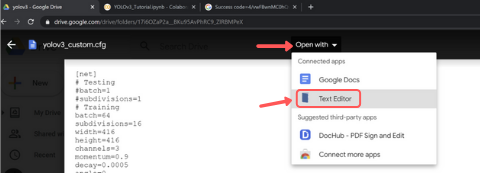

I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** 
I set my **max_batches = 6000**, **steps = 4800, 5400**, I changed the **classes = 1** in the three YOLO layers and **filters = 18** in the three convolutional layers before the YOLO layers.

How to Configure Your Variables:

width = 416

height = 416
**(these can be any multiple of 32, 416 is standard, you can sometimes improve results by making value larger like 608 but will slow down training)**

max_batches = (# of classes) * 2000
**(but no less than 6000 so if you are training for 1, 2, or 3 classes it will be 6000, however detector for 5 classes would have max_batches=10000)**

steps = (80% of max_batches), (90% of max_batches)
**(so if your max_batches = 10000, then steps = 8000, 9000)**

filters = (# of classes + 5) * 3
**(so if you are training for one class then your filters = 18, but if you are training for 4 classes then your filters = 27)**


**Optional:** If you run into memory issues or find the training taking a super long time. In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.


In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
#!cp "/mydrive/Colab Notebooks/yolov4/yolov4-obj.cfg" ./cfg
!cp "/mydrive/Colab Notebooks/yolov4/yolov4-obj-tiny-luiz-amaral-46-classes.cfg" ./cfg

# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp "/mydrive/Colab Notebooks/yolov4/obj.names" ./data
!cp "/mydrive/Colab Notebooks/yolov4/obj.data"  ./data

# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp "/mydrive/Colab Notebooks/yolov4/generate_train.py" ./
!cp "/mydrive/Colab Notebooks/yolov4/generate_test.py" ./

!cp -r "/mydrive/Colab Notebooks/yolov4/data.zip" ./data/

from zipfile import ZipFile
zip = ZipFile('./data/data.zip')
zip.extractall()


In [ ]:
!python generate_train.py
!python generate_test.py

#####   Now simply run both scripts to do the work for you of generating the two txt files.
####################################

#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
# Download the yolov4-tiny pre-trained weights file
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```


In [ ]:
#Treinar Yolov4 tiny
!./darknet detector train data/obj.data cfg/yolov4-obj-tiny-luiz-amaral-46-classes.cfg cfg yolov4-tiny.conv.29 -dont_show -map > "/mydrive/Colab/log_46classes_final.txt"


In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolov4-obj-tiny-luiz-amaral-46-classes.cfg "/mydrive/Colab/yolov4-obj-tiny-luiz-amaral-46-classes_last.weights" -dont_show -map > "/mydrive/Colab/log_46classes_final_p5_gpu.txt"

# Step 6: Checking the Mean Average Precision (mAP) of Your Model
If you didn't run the training with the '-map- flag added then you can still find out the mAP of your model after training. Run the following command on any of the saved weights from the training to see the mAP value for that specific weight's file. I would suggest to run it on multiple of the saved weights to compare and find the weights with the highest mAP as that is the most accurate one!

**NOTE:** If you think your final weights file has overfitted then it is important to run these mAP commands to see if one of the previously saved weights is a more accurate model for your classes.

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-obj-tiny-luiz-amaral-46-classes.cfg "/mydrive/Colab/yolov4-obj-tiny-luiz-amaral-46-classes_last.weights" 

# Step 7: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [ ]:
!ls /content/darknet/cfg -l

In [ ]:
# need to set our custom cfg to test mode 
%cd /content/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj-tiny-luiz-amaral-46-classes.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj-tiny-luiz-amaral-46-classes.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/Colab/yolov4-obj_last.weights /mydrive/Colab/images_teste/1.jpg #-thresh 0.3
imShow('predictions.jpg')